In [1]:
from dotenv import load_dotenv
load_dotenv()

True

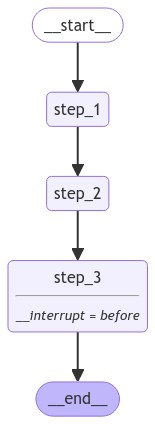

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_3"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

user_approval = input("Do you want to go to Step 3? (yes/no): ")

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        print(event)
else:
    print("Operation cancelled by user.")

{'input': 'hello world'}
---Step 1---
---Step 2---
---Step 3---


In [4]:
from src.agent import AgentState, StateGraph, Agent
from langchain.globals import set_debug
from src.logger_setup import logger
from langgraph.checkpoint.memory import MemorySaver
import json

from langchain.globals import set_verbose
from langchain.globals import set_debug
from pprint import pprint

class WorkFlow:

    def __init__(self, prompt, plotting_graph_structure=False, debug=False, is_verbose:bool=True) -> None:
        
        #set_debug(is_verbose) 
        self.plotting_graph_structure = plotting_graph_structure
        self.prompt = prompt
        self.agent = Agent()
        self.memory = MemorySaver()
        self.thread = {"configurable": {"thread_id": "1"}}

    def setting_workflow(self):

        self.workflow = StateGraph(AgentState)

        self.workflow.add_node("call_model", self.agent.call_model)
        self.workflow.add_node("execute_sql_query", self.agent.execute_sql_query)
        self.workflow.add_node("execute_python", self.agent.execute_python)

        self.workflow.set_entry_point("call_model")
        self.workflow.add_edge("execute_sql_query", "execute_python")
        self.workflow.add_edge("execute_python", "call_model")
        self.workflow.add_conditional_edges("call_model", self.agent.should_continue)
        #self.app = self.workflow.compile()
        self.app = self.workflow.compile(checkpointer=self.memory, interrupt_before=["execute_sql_query"])

    def running_agent(self):

        self.setting_workflow()
        if self.plotting_graph_structure:
            self.app.get_graph().draw_mermaid_png(output_file_path="graph.png")


        inputs = {"messages": [("human", self.prompt)]}

  
        #output = self.app.invoke({"messages": [("human", self.prompt)]})
        for event in self.app.stream({"messages": [("human", self.prompt)]}, self.thread):
            logger.info(event)

        #Getting the SQL query        
        # arguments_str = event['messages'][1].additional_kwargs['tool_calls'][0]['function']['arguments']
        # arguments_dict = json.loads(arguments_str)
        # select_query = arguments_dict['select_query']
        # logger.info(f'\n\n\nQUERY: {select_query}\n' )

        user_approval = input("Do you want to go execute the query? (yes/no): ")
        from pprint import pprint
        if user_approval.lower() == "yes":
            # If approved, continue the graph execution
            #self.app.invoke(None, self.thread)
            for event in self.app.stream(None, config = self.thread):
                print('\n'*5)
                pprint(event)

        else:
            logger.info("Operation cancelled by user.")




if __name__ == "__main__":
    workflow=WorkFlow(prompt="graph the total sales values")
    workflow.running_agent()

2024-08-21 22:06:46,895 - INFO - 377320947.py - {'call_model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9sI3dFCGwNAPRyjlQxsARVBP', 'function': {'arguments': '{"select_query":"SELECT sale_date, quantity, unit_price FROM sales","df_columns":["sale_date","quantity","unit_price"],"df_name":"sales_df"}', 'name': 'create_df_from_sql'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 343, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_2a322c9ffc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bf365118-7235-463c-a1fc-80a483b20c45-0', tool_calls=[{'name': 'create_df_from_sql', 'args': {'select_query': 'SELECT sale_date, quantity, unit_price FROM sales', 'df_columns': ['sale_date', 'quantity', 'unit_price'], 'df_name': 'sales_df'}, 'id': 'call_9sI3dFCGwNAPRyjlQxsARVBP', 'type': 'tool_call'}], usage_metadata={'input_tokens': 343, 'output_tokens': 44, 'total







{'execute_sql_query': {'messages': [RawToolMessage(content="Generated dataframe sales_df with columns ['sale_date', 'quantity', 'unit_price']", tool_call_id='call_9sI3dFCGwNAPRyjlQxsARVBP', raw={'sales_df': '[{"sale_date":1705276800000,"quantity":100,"unit_price":9.99},{"sale_date":1705363200000,"quantity":50,"unit_price":24.99},{"sale_date":1705449600000,"quantity":75,"unit_price":14.5}]'}, tool_name='create_df_from_sql')]}}






{'execute_python': {'messages': []}}






{'call_model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kJSiHL3g0t11oftmPIgM3cRd', 'function': {'arguments': '{"imports":"import pandas as pd\\nimport matplotlib.pyplot as plt","code":"# Calculate total sales value for each date\\nsales_df[\'total_sales\'] = sales_df[\'quantity\'] * sales_df[\'unit_price\']\\n\\n# Plotting the total sales values\\nplt.figure(figsize=(10, 6))\\nplt.plot(sales_df[\'sale_date\'], sales_df[\'total_sales\'], marker=\'o\')\\nplt.title(\'Tota

In [1]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph

builder = StateGraph(int)
builder.add_node("add_one", lambda x: x + 1)
builder.set_entry_point("add_one")
builder.set_finish_point("add_one")
conn = sqlite3.connect("checkpoints.sqlite3")
memory = SqliteSaver(conn)
graph = builder.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "1"}}
graph.get_state(config)
result = graph.invoke(3, config)
graph.get_state(config)
StateSnapshot(values=4, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '0c62ca34-ac19-445d-bbb0-5b4984975b2a'}}, parent_config=None)

ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140337279110016 and this is thread id 140336579999296.

In [3]:
from typing import Annotated, List, Sequence, TypedDict
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import END, StateGraph
import operator
from src.database_handler import DatabaseHandler
from src.config_handler import ConfigHandler
import pandas as pd
import io
import base64
import json
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.utils import PathInfo
from src.logger_setup import logger
import shutil
from langfuse.callback import CallbackHandler
from src.tools_schema import create_df_from_sql, python_shell
from io import StringIO


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

class RawToolMessage(ToolMessage):
    """
    Customized Tool message that lets us pass around the raw tool outputs (along with string contents for passing back to the model).
    """

    raw: dict
    """Arbitrary (non-string) tool outputs. Won't be sent to model."""
    tool_name: str
    """Name of tool that generated output."""


class Agent:

    def __init__(self, save_image=False):
        self.db = DatabaseHandler()
        self.config = ConfigHandler()
        self.config_handler = ConfigHandler()
        self.db = self.db.db
        self.llm = self.config.llm
        self.repl_tool = self.config.repl_tool
        self.repl = self.config.repl
        self.save_image = save_image
        self.langfuse_handler = CallbackHandler()

        self.system_prompt = f"""\
                            You are an expert at PostgreSQL and Python. You have access to a PostgreSQL database \
                            with the following tables

                            {self.db.table_info}

                            Given a user question related to the data in the database, \
                            first get the relevant data from the table as a DataFrame using the create_df_from_sql tool. Then use the \
                            python_shell to do any analysis required to answer the user question."""

        self.prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_prompt),
                ("placeholder", "{messages}"),
            ]
        )


    def call_model(self, state: AgentState) -> dict:
        """Call model with tools passed in."""
        messages = []

        chain = self.prompt | self.llm.bind_tools([create_df_from_sql, python_shell])
        messages.append(chain.invoke({"messages": state["messages"]}))

        return {"messages": messages}

    def execute_sql_query(self, state: AgentState) -> dict:
        """Execute the latest SQL queries."""
        messages = []

        for tool_call in state["messages"][-1].tool_calls:
            if tool_call["name"] != "create_df_from_sql":
                continue

            # Execute SQL query
            logger.info(f'Executing SQL query: {tool_call["args"]["select_query"]}')

            res = self.db.run(tool_call["args"]["select_query"], fetch="cursor").fetchall()
          
            # Convert result to Pandas DataFrame
            df_columns = tool_call["args"]["df_columns"]
            df = pd.DataFrame(res, columns=df_columns)
            df_name = tool_call["args"]["df_name"]

            # Add tool output message
            messages.append(
                RawToolMessage(
                    f"Generated dataframe {df_name} with columns {df_columns}",  # What's sent to model.
                    raw={df_name: df.to_json(orient='records', lines=False)},
                    tool_call_id=tool_call["id"],
                    tool_name=tool_call["name"],
                )
            )

        return {"messages": messages}

    def _upload_dfs_to_repl(self, state: AgentState) -> str:
        """
        Upload generated dfs to code interpreter and return code for loading them.

        Note that code interpreter sessions are short-lived, so this needs to be done
        every agent cycle, even if the dfs were previously uploaded.
        """
        df_dicts = [
            msg.raw
            for msg in state["messages"]
            if isinstance(msg, RawToolMessage) and msg.tool_name == "create_df_from_sql"
        ]
        name_df_map = {name: df for df_dict in df_dicts for name, df in df_dict.items()}

        for name, df in name_df_map.items():
            
            buffer = io.StringIO()
            logger.info(f"Saving dataFrame {name} as a csv file.")
            df = pd.read_json(StringIO(df), orient='records')
            df.to_csv(f'{PathInfo.CSV_PATH}/{name}.csv')
            buffer.seek(0)  

        # Code for loading the uploaded files (read from /data inside the container)
        df_code = "import pandas as pd\n" + "\n".join(
            f"{name} = pd.read_csv('/data/{name}.csv')" for name in name_df_map  
        )
        return df_code

    def _repl_result_to_msg_content(self, repl_result: dict) -> str:
        """
        Display images and include them in tool message content.
        """
        content = {}

        for k, v in repl_result.items():
            # Any image results are returned as a dict of the form:
            # {"type": "image", "base64_data": "..."}
            if isinstance(repl_result[k], dict) and repl_result[k]["type"] == "image":
                warnings.filterwarnings("ignore", category=UserWarning, message=".*Matplotlib.*GUI.*")
                base64_str = repl_result[k]["base64_data"]
                image_data = base64.b64decode(base64_str)
                image = mpimg.imread(io.BytesIO(image_data), format='png')
                plt.imshow(image)
                plt.axis('off')
                plt.show()

                if self.save_image:
                    #You can optionally save the image to a file:
                    with open(f"{PathInfo.DATA_FOLDER_PATH}/plot_from_docker.png", "wb") as f:
                        f.write(image_data)

            else:
                # Handle non-image output
                content[k] = repl_result[k]

        return json.dumps(content, indent=2)

    def execute_python(self, state: AgentState) -> dict:
        """
        Execute the latest generated Python code.
        """
        messages = []

        df_code = self._upload_dfs_to_repl(state)
        last_ai_msg = [msg for msg in state["messages"] if isinstance(msg, AIMessage)][-1]
        for tool_call in last_ai_msg.tool_calls:
            if tool_call["name"] != "python_shell":
                continue

            #generated_code = tool_call["args"]["code"]

            code_dict = {'code_to_load_csv': df_code,
                        'imports': tool_call["args"]["imports"],
                        'code_block_without_imports': tool_call["args"]["code"],}
            
            repl_result = self.config_handler.invoke_repl(code_dict)

            #repl_result = self.config_handler.invoke_repl(df_code + "\n" + generated_code)

            messages.append(
                RawToolMessage(
                    self._repl_result_to_msg_content(repl_result),
                    raw=repl_result,
                    tool_call_id=tool_call["id"],
                    tool_name=tool_call["name"],
                )
            )
        return {"messages": messages}

    def should_continue(self, state: AgentState) -> str:
        """
        If any Tool messages were generated in the last cycle that means we need to call the model again to interpret the latest results.
        """
        last_message = state["messages"][-1]
        if last_message.tool_calls:
            # Check if the last tool call was 'python_shell' and it returned a result
            last_tool_call = last_message.tool_calls[-1]
            if last_tool_call["name"] == "python_shell" and last_tool_call.get("output"):
                return END  # Stop the loop if python_shell returned a result
            else:
                return "execute_sql_query"
        else:
            return END
        










#from src.agent import AgentState, StateGraph, Agent
from langchain.globals import set_debug
from src.logger_setup import logger
from langgraph.checkpoint.memory import MemorySaver
import json

from langchain.globals import set_verbose
from langchain.globals import set_debug
from pprint import pprint
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph



class WorkFlow:

    def __init__(self, prompt, plotting_graph_structure=False, debug=False, is_verbose:bool=True) -> None:
        
        #set_debug(is_verbose) 
        self.plotting_graph_structure = plotting_graph_structure
        self.prompt = prompt
        self.agent = Agent()
        conn = sqlite3.connect("checkpoints.sqlite4", check_same_thread=False)
        self.memory = SqliteSaver(conn)
        #self.memory = MemorySaver()
        self.thread = {"configurable": {"thread_id": "1"}}

    def setting_workflow(self):

        self.workflow = StateGraph(AgentState)

        self.workflow.add_node("call_model", self.agent.call_model)
        self.workflow.add_node("execute_sql_query", self.agent.execute_sql_query)
        self.workflow.add_node("execute_python", self.agent.execute_python)

        self.workflow.set_entry_point("call_model")
        self.workflow.add_edge("execute_sql_query", "execute_python")
        self.workflow.add_edge("execute_python", "call_model")
        self.workflow.add_conditional_edges("call_model", self.agent.should_continue)
        #self.app = self.workflow.compile()
        self.app = self.workflow.compile(checkpointer=self.memory, interrupt_before=["execute_sql_query"])

    def running_agent(self):

        self.setting_workflow()
        if self.plotting_graph_structure:
            self.app.get_graph().draw_mermaid_png(output_file_path="graph.png")


        inputs = {"messages": [("human", self.prompt)]}

  
        #output = self.app.invoke({"messages": [("human", self.prompt)]})
        for event in self.app.stream({"messages": [("human", self.prompt)]}, self.thread):
            logger.info(event)

        #Getting the SQL query        
        # arguments_str = event['messages'][1].additional_kwargs['tool_calls'][0]['function']['arguments']
        # arguments_dict = json.loads(arguments_str)
        # select_query = arguments_dict['select_query']
        # logger.info(f'\n\n\nQUERY: {select_query}\n' )

        user_approval = input("Do you want to go execute the query? (yes/no): ")
        from pprint import pprint
        if user_approval.lower() == "yes":
            # If approved, continue the graph execution
            #self.app.invoke(None, self.thread)
            for event in self.app.stream(None, config = self.thread):
                print('\n'*5)
                pprint(event)

        else:
            logger.info("Operation cancelled by user.")




if __name__ == "__main__":
    workflow=WorkFlow(prompt="graph the total sales values")
    workflow.running_agent()

2024-08-21 22:16:00,732 - INFO - 1974904134.py - {'call_model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M6dbHr7xcTnLBXKg32sAwQ1S', 'function': {'arguments': '{"select_query":"SELECT sale_date, quantity, unit_price FROM sales","df_columns":["sale_date","quantity","unit_price"],"df_name":"sales_df"}', 'name': 'create_df_from_sql'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 343, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_2a322c9ffc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a051776f-8baf-4cb7-923a-57b6db1bdea6-0', tool_calls=[{'name': 'create_df_from_sql', 'args': {'select_query': 'SELECT sale_date, quantity, unit_price FROM sales', 'df_columns': ['sale_date', 'quantity', 'unit_price'], 'df_name': 'sales_df'}, 'id': 'call_M6dbHr7xcTnLBXKg32sAwQ1S', 'type': 'tool_call'}], usage_metadata={'input_tokens': 343, 'output_tokens': 44, 'tota







{'execute_sql_query': {'messages': [RawToolMessage(content="Generated dataframe sales_df with columns ['sale_date', 'quantity', 'unit_price']", tool_call_id='call_M6dbHr7xcTnLBXKg32sAwQ1S', raw={'sales_df': '[{"sale_date":1705276800000,"quantity":100,"unit_price":9.99},{"sale_date":1705363200000,"quantity":50,"unit_price":24.99},{"sale_date":1705449600000,"quantity":75,"unit_price":14.5}]'}, tool_name='create_df_from_sql')]}}






{'execute_python': {'messages': []}}






{'call_model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zsin6IDbxfXRz4U0Xb68QyVx', 'function': {'arguments': '{"imports":"import pandas as pd\\nimport matplotlib.pyplot as plt","code":"# Calculate the total sales value for each date\\nsales_df[\'total_sales\'] = sales_df[\'quantity\'] * sales_df[\'unit_price\']\\n\\n# Plotting the total sales values\\ndates = pd.to_datetime(sales_df[\'sale_date\'])\\ntotal_sales = sales_df[\'total_sales\']\\n\\nplt.figure(figsize=(10, 

In [12]:


#from src.agent import AgentState, StateGraph, Agent
from langchain.globals import set_debug
from src.logger_setup import logger
from langgraph.checkpoint.memory import MemorySaver
import json

from langchain.globals import set_verbose
from langchain.globals import set_debug
from pprint import pprint
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph

class State(TypedDict):
    input: str
    user_feedback: str

class WorkFlow:

    def __init__(self, prompt, plotting_graph_structure=False, debug=False, is_verbose:bool=True) -> None:
        
        #set_debug(is_verbose) 
        self.plotting_graph_structure = plotting_graph_structure
        self.prompt = prompt
        self.agent = Agent()
        self.memory = MemorySaver()
    

    def human_prompt(self, state):
        print("---Human Prompt---")
        pass


    def supervisor_agent(self,state):
        print("---Supervisor Agent---")
        pass


    def sql_agent(self,state):
        print("---SQL Agent---")
        pass


    def rag_agent(self,state):
        print("---RAG Agent---")
        pass

    def dataviz_agent(self,state):
        print("---DataViz Agent---")
        pass


    def should_continue(self, state: AgentState) -> str:
        """
        If any Tool messages were generated in the last cycle that means we need to call the model again to interpret the latest results.
        """
        last_message = state["messages"][-1]
        if last_message.tool_calls:
            # Check if the last tool call was 'python_shell' and it returned a result
            last_tool_call = last_message.tool_calls[-1]
            if last_tool_call["name"] == "python_shell" and last_tool_call.get("output"):
                return END  # Stop the loop if python_shell returned a result
            else:
                return "execute_sql_query"
        else:
            return END


    def setting_workflow(self):

        self.workflow = StateGraph(AgentState)

        self.workflow.add_node("Supervisor Agent", self.supervisor_agent)
        self.workflow.add_node("SQL Agent", self.sql_agent)
        self.workflow.add_node("RAG Agent", self.rag_agent)
        self.workflow.add_node("Data Viz Agent", self.dataviz_agent)
        

        self.workflow.set_entry_point("Supervisor Agent")
        self.workflow.add_edge("RAG Agent", "Supervisor Agent")
        self.workflow.add_edge("SQL Agent", "Supervisor Agent")
        self.workflow.add_edge("Data Viz Agent", "Supervisor Agent")
        # self.workflow.add_conditional_edges("Supervisor Agent", "SQL Agent")
        # self.workflow.add_conditional_edges("Supervisor Agent", "RAG Agent")
        # self.workflow.add_conditional_edges("Supervisor Agent", "Data Viz Agent")
        self.workflow.add_conditional_edges("Supervisor Agent", self.should_continue)
        self.app = self.workflow.compile()

    def running_agent(self):

        self.setting_workflow()

        self.app.get_graph().draw_mermaid_png(output_file_path="graph_teste.png")

        inputs = {"messages": [("human", self.prompt)]}
 
        output = self.app.invoke({"messages": [("human", self.prompt)]})

        
if __name__ == "__main__":
    workflow=WorkFlow(prompt="graph the total sales values")
    workflow.running_agent()

---Supervisor Agent---


AttributeError: 'tuple' object has no attribute 'tool_calls'